# Image Segmentation using TensorFlow

In [4]:
import datetime
import os
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import (
    Flatten, Dense, Reshape, Conv2D, MaxPool2D, Conv2DTranspose
    )
import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = 'Greys_r'

In [5]:
# loading the training and test sets from TFRecords
raw_training_dataset = tf.data.TFRecordDataset('data/train_images.tfrecords')
raw_val_dataset      = tf.data.TFRecordDataset('data/val_images.tfrecords')

In [6]:
# dictionary describing the fields stored in TFRecord, and used to extract the date from the TFRecords
image_feature_description = {
    'height':    tf.io.FixedLenFeature([], tf.int64),
    'width':     tf.io.FixedLenFeature([], tf.int64),
    'depth':     tf.io.FixedLenFeature([], tf.int64),
    'name' :     tf.io.FixedLenFeature([], tf.string),
    'image_raw': tf.io.FixedLenFeature([], tf.string),
    'label_raw': tf.io.FixedLenFeature([], tf.string),
}


In [7]:
# helper function to extract an image from the dictionary
def _parse_image_function(example_proto):
    return tf.io.parse_single_example(example_proto, image_feature_description)

parsed_training_dataset = raw_training_dataset.map(_parse_image_function)
parsed_val_dataset      = raw_val_dataset.map(_parse_image_function)

In [8]:
print(len(list(parsed_training_dataset)))
print(len(list(parsed_val_dataset)))

234
26


In [9]:
# function to read and decode an example from the parsed dataset
@tf.function
def read_and_decode(example):
    image_raw = tf.io.decode_raw(example['image_raw'], tf.int64)
    image_raw.set_shape([65536])
    image = tf.reshape(image_raw, [256, 256, 1])

    image = tf.cast(image, tf.float32) * (1. / 1024)

    label_raw = tf.io.decode_raw(example['label_raw'], tf.uint8)
    label_raw.set_shape([65536])
    label = tf.reshape(label_raw, [256, 256, 1])

    return image, label

In [10]:
# get datasets read and decoded, and into a state usable by TensorFlow
tf_autotune = tf.data.experimental.AUTOTUNE
train = parsed_training_dataset.map(read_and_decode, num_parallel_calls=tf_autotune)
val = parsed_val_dataset.map(read_and_decode)
train.element_spec

(TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))

In [11]:
# setup the buffer size and batch size for data reading and training
BUFFER_SIZE = 10
BATCH_SIZE = 1

In [12]:
# setup the train and test data by shuffling, prefetching, etc
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf_autotune)
test_dataset  = val.batch(BATCH_SIZE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.uint8, name=None))>

In [13]:
# helper function to display an image, it's label and the prediction
def display(display_list):
    plt.figure(figsize=(10, 10))
    title = ['Input Image', 'Label', 'Predicted Label']

    for i in range(len(display_list)):
        display_resized = tf.reshape(display_list[i], [256, 256])
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_resized)
        plt.axis('off')
    plt.show()

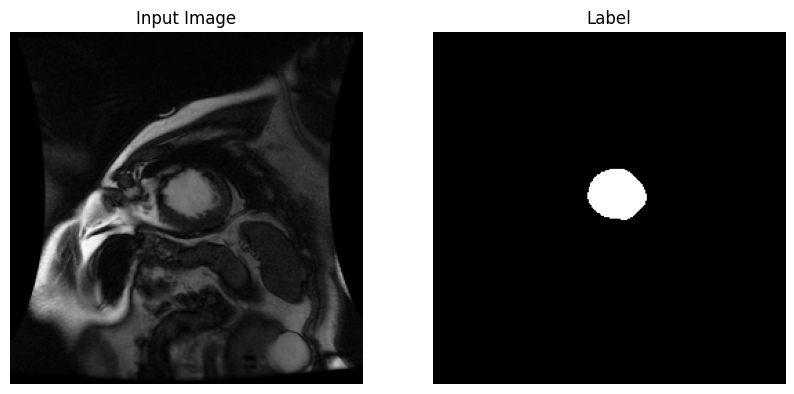

In [14]:
# display an image and label from the training set
for image, label in train.take(1):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

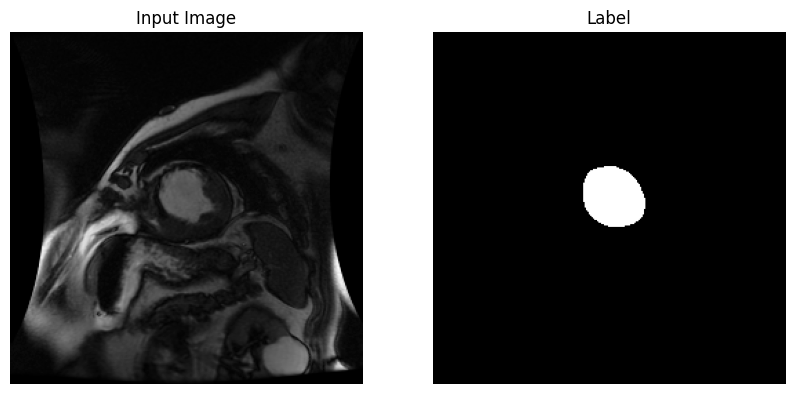

In [15]:
# display an image and label from the test set
for image, label in val.take(1):
    sample_image, sample_label = image, label
    display([sample_image, sample_label])

# Fully-connected NN with one hidden layer


In [16]:
tf.keras.backend.clear_session()

# set up the model architecture
model = tf.keras.models.Sequential([
    Flatten(input_shape=[256, 256, 1]),
    Dense(64, activation='relu'),
    Dense(256*256*2, activation='softmax'),
    Reshape((256, 256, 2))
])

# specify how to train the model with algorithm, the loss function and metrics
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

g:\Desktop\Project\LLMHobbyProjects\ImageSegmentation\myenv\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [17]:
# print out the summary of the model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 131072)         │     8,519,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 256, 256, 2)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,714,048 (48.50 MB)

 Trainable params: 12,714,048 (48.50 MB)

 Non-trainable params: 0 (0.00 B)

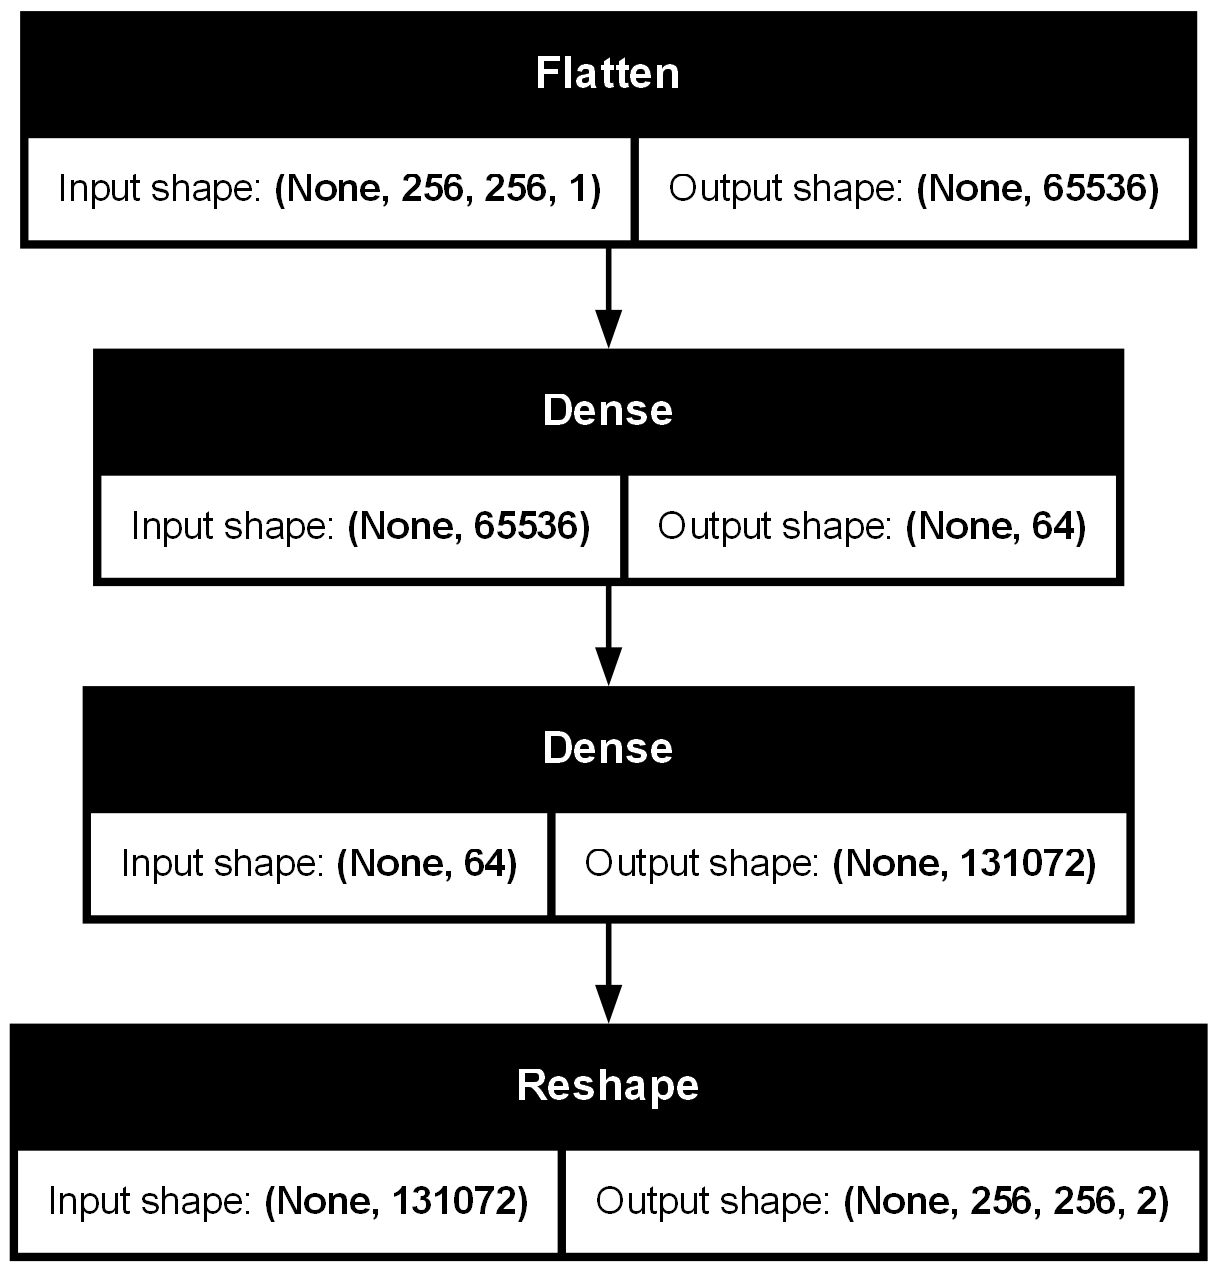

In [18]:
# plot the model including the sizes of the model
tf.keras.utils.plot_model(model, show_shapes=True)

In [19]:
# function to take a prediction from the model and output an image for display
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [20]:
# helper function to show the image, the label and the prediction
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, label in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], label[0], create_mask(pred_mask)])
    else:
        prediction = create_mask(model.predict(sample_image[tf.newaxis, ...]))
        display([sample_image, sample_label, prediction])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


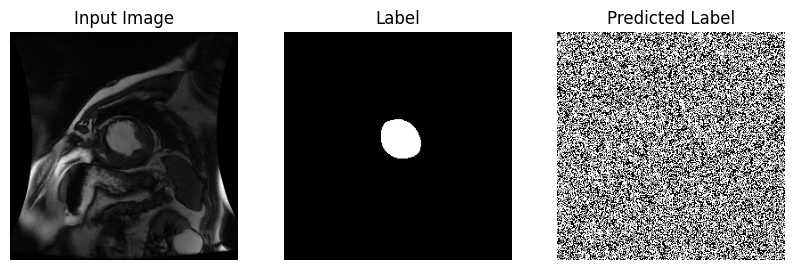

In [21]:
# show a predection, as an example
show_predictions(test_dataset)

In [22]:
# define a callback that shows image predictions on the test set
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# setup a tensorboard callback
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step/step - accuracy: 0.4997 - loss: 0.693


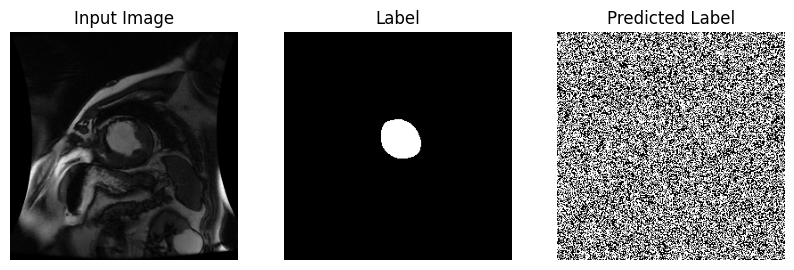


Sample Prediction after epoch 1

234/234 ━━━━━━━━━━━━━━━━━━━━ 81s 339ms/step - accuracy: 0.4997 - loss: 0.6931 - val_accuracy: 0.5093 - val_loss: 0.6931
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/stepstep - accuracy: 0.5131 - loss: 0.69


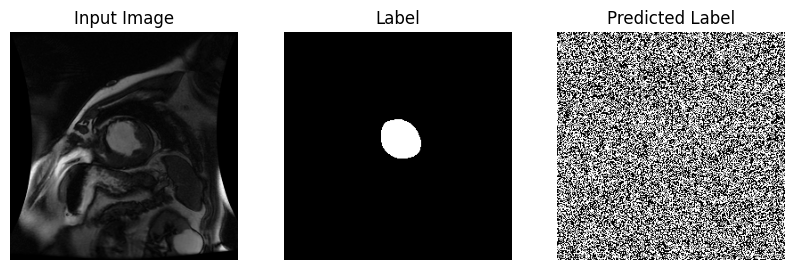


Sample Prediction after epoch 2

234/234 ━━━━━━━━━━━━━━━━━━━━ 73s 267ms/step - accuracy: 0.5132 - loss: 0.6931 - val_accuracy: 0.5276 - val_loss: 0.6931
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/stepstep - accuracy: 0.5328 - loss: 0.69


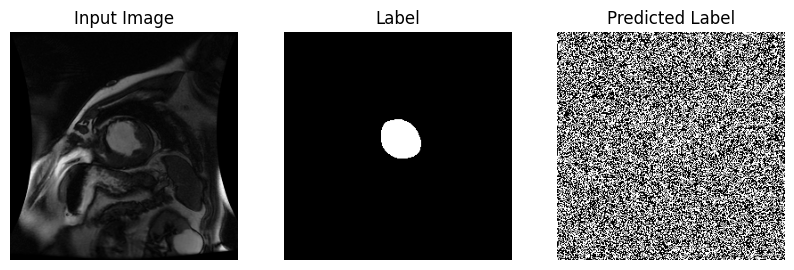


Sample Prediction after epoch 3

234/234 ━━━━━━━━━━━━━━━━━━━━ 45s 192ms/step - accuracy: 0.5328 - loss: 0.6931 - val_accuracy: 0.5534 - val_loss: 0.6931
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/stepstep - accuracy: 0.5639 - loss: 0.693


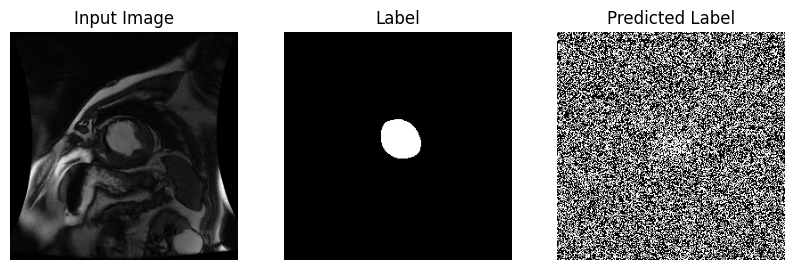


Sample Prediction after epoch 4

234/234 ━━━━━━━━━━━━━━━━━━━━ 42s 179ms/step - accuracy: 0.5639 - loss: 0.6931 - val_accuracy: 0.6108 - val_loss: 0.6931
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/stepstep - accuracy: 0.6370 - loss: 0.69


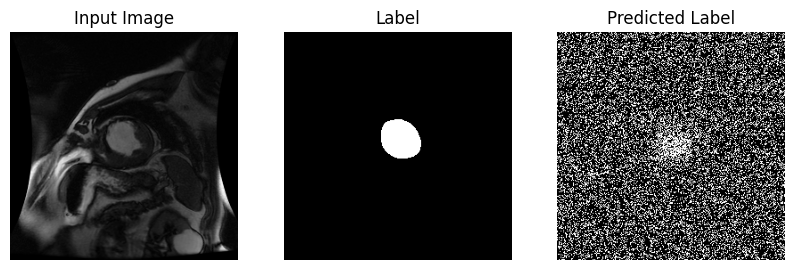


Sample Prediction after epoch 5

234/234 ━━━━━━━━━━━━━━━━━━━━ 69s 295ms/step - accuracy: 0.6371 - loss: 0.6931 - val_accuracy: 0.7485 - val_loss: 0.6931
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/stepstep - accuracy: 0.8008 - loss: 0.693


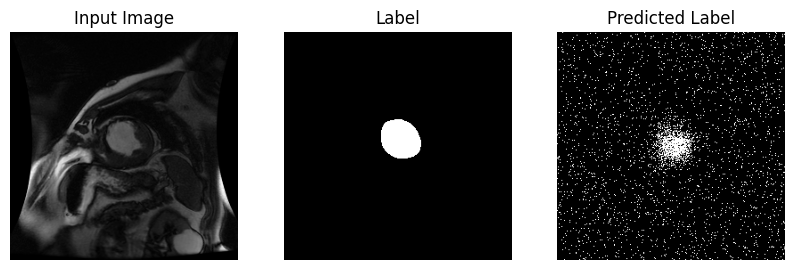


Sample Prediction after epoch 6

234/234 ━━━━━━━━━━━━━━━━━━━━ 44s 188ms/step - accuracy: 0.8010 - loss: 0.6931 - val_accuracy: 0.9507 - val_loss: 0.6931
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/stepstep - accuracy: 0.9697 - loss: 0.693


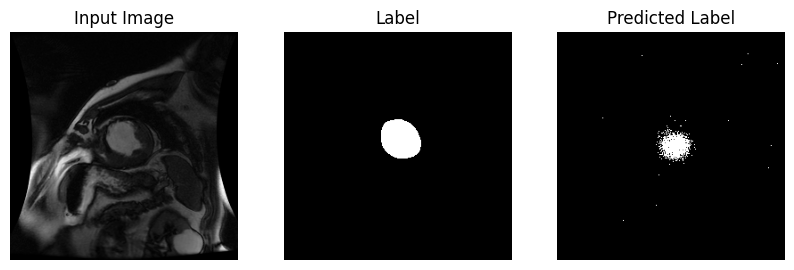


Sample Prediction after epoch 7

234/234 ━━━━━━━━━━━━━━━━━━━━ 47s 203ms/step - accuracy: 0.9697 - loss: 0.6931 - val_accuracy: 0.9867 - val_loss: 0.6931
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/stepms/step - accuracy: 0.9874 - loss: 0.693


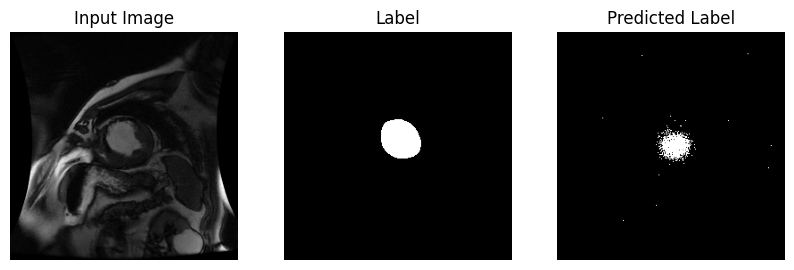


Sample Prediction after epoch 8

234/234 ━━━━━━━━━━━━━━━━━━━━ 99s 422ms/step - accuracy: 0.9874 - loss: 0.6931 - val_accuracy: 0.9867 - val_loss: 0.6931
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step/step - accuracy: 0.9876 - loss: 0.693


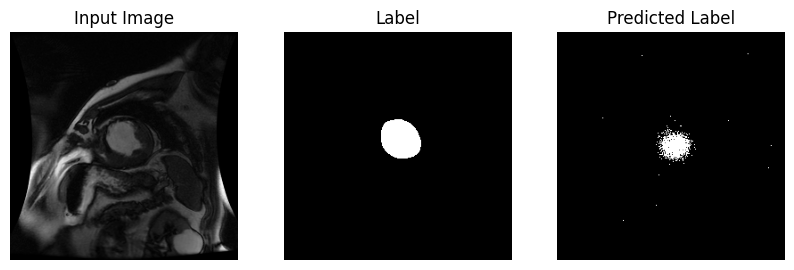


Sample Prediction after epoch 9

234/234 ━━━━━━━━━━━━━━━━━━━━ 42s 180ms/step - accuracy: 0.9876 - loss: 0.6931 - val_accuracy: 0.9867 - val_loss: 0.6931
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step/step - accuracy: 0.9876 - loss: 0.693


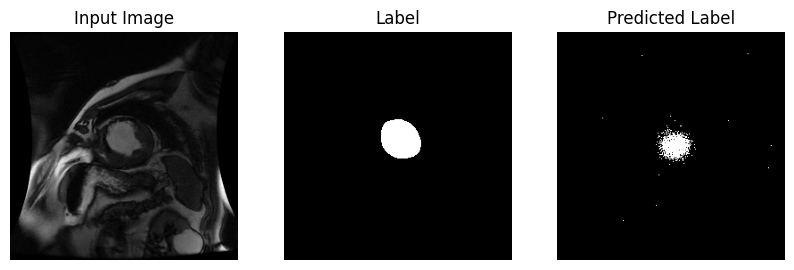


Sample Prediction after epoch 10

234/234 ━━━━━━━━━━━━━━━━━━━━ 45s 193ms/step - accuracy: 0.9876 - loss: 0.6931 - val_accuracy: 0.9867 - val_loss: 0.6931
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step/step - accuracy: 0.9876 - loss: 0.693


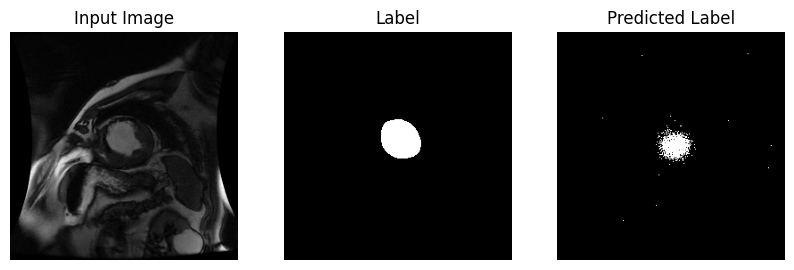


Sample Prediction after epoch 11

234/234 ━━━━━━━━━━━━━━━━━━━━ 43s 184ms/step - accuracy: 0.9876 - loss: 0.6931 - val_accuracy: 0.9867 - val_loss: 0.6931
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/stepstep - accuracy: 0.9873 - loss: 0.69


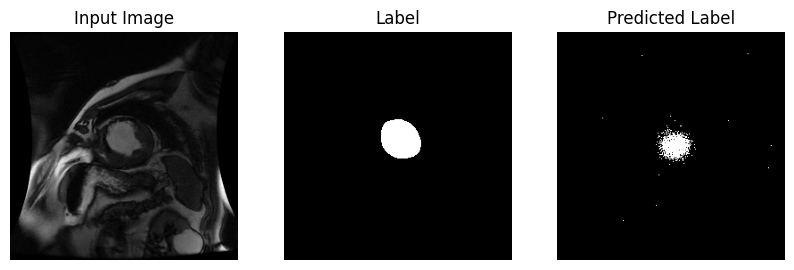


Sample Prediction after epoch 12

234/234 ━━━━━━━━━━━━━━━━━━━━ 47s 203ms/step - accuracy: 0.9873 - loss: 0.6931 - val_accuracy: 0.9867 - val_loss: 0.6931
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step/step - accuracy: 0.9876 - loss: 0.693


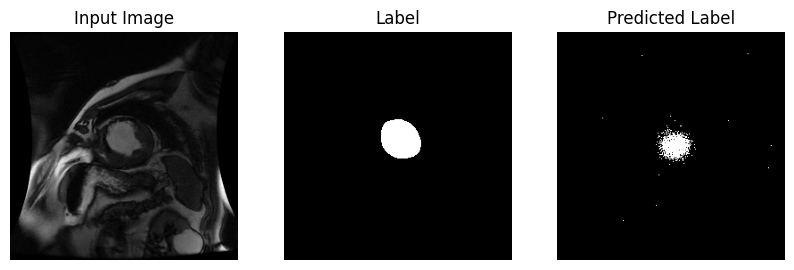


Sample Prediction after epoch 13

234/234 ━━━━━━━━━━━━━━━━━━━━ 43s 183ms/step - accuracy: 0.9876 - loss: 0.6931 - val_accuracy: 0.9867 - val_loss: 0.6931
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step/step - accuracy: 0.9875 - loss: 0.693


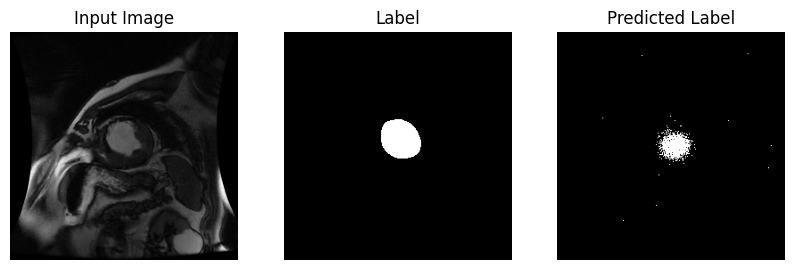


Sample Prediction after epoch 14

234/234 ━━━━━━━━━━━━━━━━━━━━ 44s 188ms/step - accuracy: 0.9875 - loss: 0.6931 - val_accuracy: 0.9867 - val_loss: 0.6931
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step/step - accuracy: 0.9874 - loss: 0.693


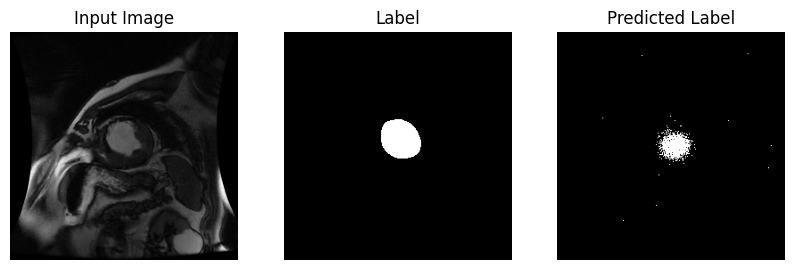


Sample Prediction after epoch 15

234/234 ━━━━━━━━━━━━━━━━━━━━ 42s 181ms/step - accuracy: 0.9874 - loss: 0.6931 - val_accuracy: 0.9867 - val_loss: 0.6931
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step/step - accuracy: 0.9875 - loss: 0.693


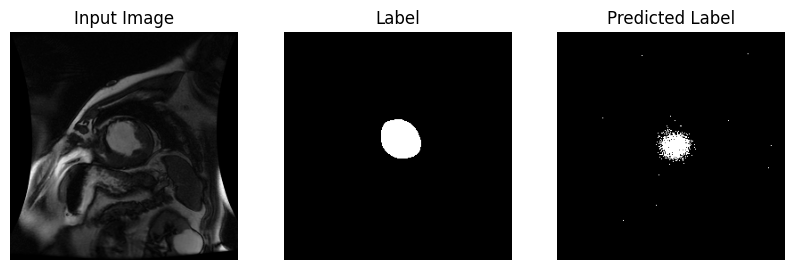


Sample Prediction after epoch 16

234/234 ━━━━━━━━━━━━━━━━━━━━ 44s 190ms/step - accuracy: 0.9875 - loss: 0.6931 - val_accuracy: 0.9867 - val_loss: 0.6931
Epoch 17/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step/step - accuracy: 0.9875 - loss: 0.693


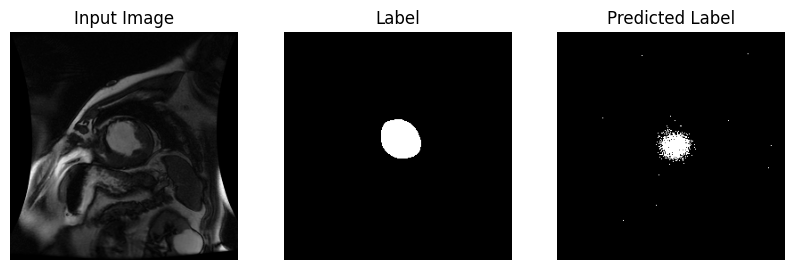


Sample Prediction after epoch 17

234/234 ━━━━━━━━━━━━━━━━━━━━ 43s 185ms/step - accuracy: 0.9874 - loss: 0.6931 - val_accuracy: 0.9867 - val_loss: 0.6931
Epoch 18/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step/step - accuracy: 0.9876 - loss: 0.693


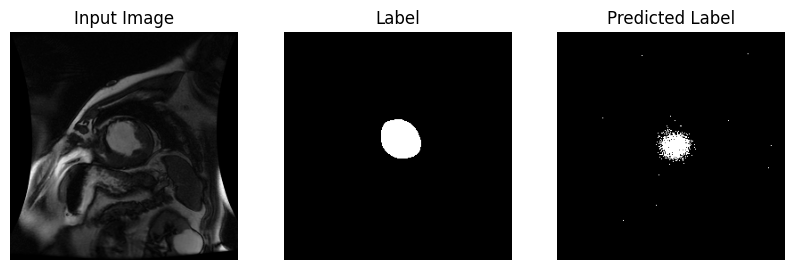


Sample Prediction after epoch 18

234/234 ━━━━━━━━━━━━━━━━━━━━ 43s 182ms/step - accuracy: 0.9876 - loss: 0.6931 - val_accuracy: 0.9867 - val_loss: 0.6931
Epoch 19/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step/step - accuracy: 0.9876 - loss: 0.693


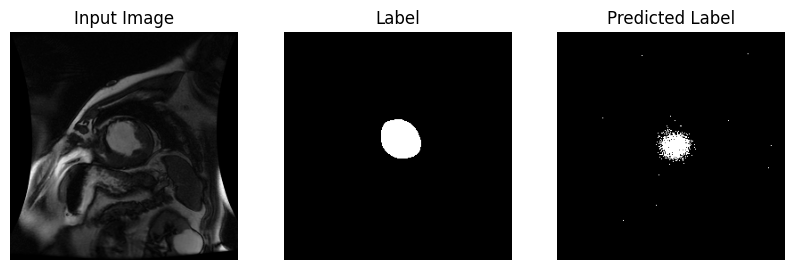


Sample Prediction after epoch 19

234/234 ━━━━━━━━━━━━━━━━━━━━ 43s 183ms/step - accuracy: 0.9876 - loss: 0.6931 - val_accuracy: 0.9867 - val_loss: 0.6931
Epoch 20/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step/step - accuracy: 0.9874 - loss: 0.693


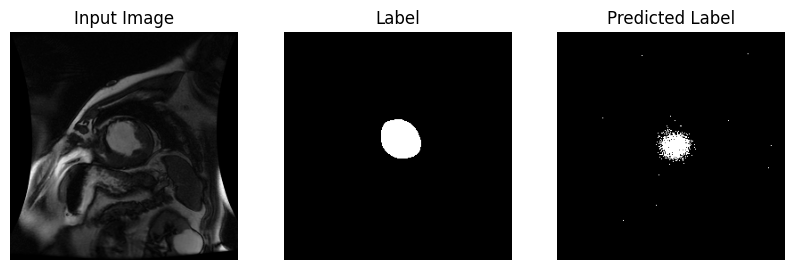


Sample Prediction after epoch 20

234/234 ━━━━━━━━━━━━━━━━━━━━ 43s 182ms/step - accuracy: 0.9874 - loss: 0.6931 - val_accuracy: 0.9867 - val_loss: 0.6931


In [23]:
# setup and run the model
EPOCHS = 20
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
VALIDATION_STEPS = 26

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback])

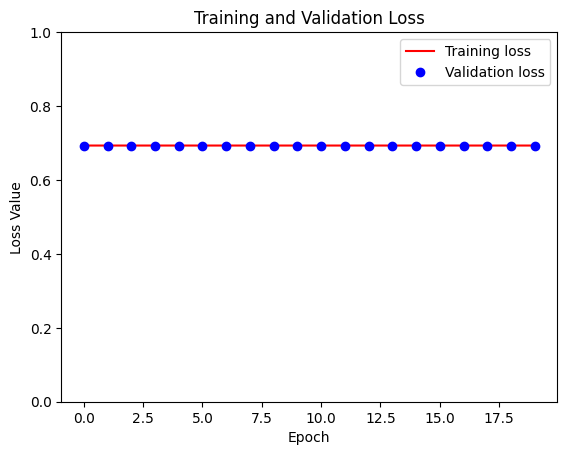

In [24]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Model Evaluation

In [25]:
model.evaluate(test_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.9853 - loss: 0.6931


g:\Desktop\Project\LLMHobbyProjects\ImageSegmentation\myenv\lib\site-packages\keras\src\trainers\epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


[0.6931389570236206, 0.986744225025177]

In [26]:
%load_ext tensorboard

In [27]:
%tensorboard --logdir logs

ERROR: Failed to launch TensorBoard (exited with 1).

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


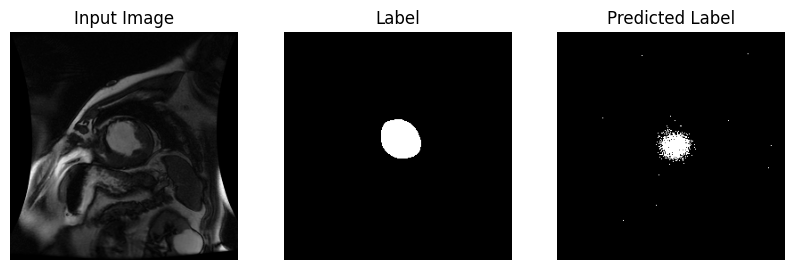

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


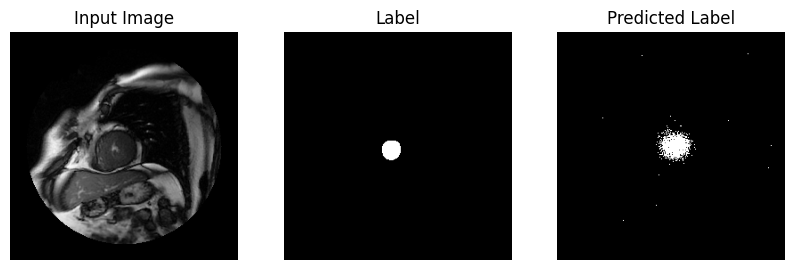

In [29]:
show_predictions(test_dataset, 2)

# Convolutional Neural Network (CNN)

In [31]:
tf.keras.backend.clear_session()

# set up the model architecture

layers = [
    Conv2D(input_shape=[256, 256, 1],
           filters=100,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu,
           name="Conv1"),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=200,
           kernel_size=5,
           strides=2,
           padding="same",
           activation=tf.nn.relu),
    MaxPool2D(pool_size=2, strides=2, padding="same"),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=300,
           kernel_size=3,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2D(filters=2,
           kernel_size=1,
           strides=1,
           padding="same",
           activation=tf.nn.relu),
    Conv2DTranspose(filters=2, kernel_size=31, strides=16, padding="same")
]


In [33]:
model = tf.keras.models.Sequential(layers)

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [35]:
# print out the summary of the model
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1 (Conv2D)                  │ (None, 128, 128, 100)  │         2,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 100)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 200)    │       500,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 200)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 300)    │       540,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 300)    │       810,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 2)      │           602 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 256, 256, 2)    │         3,846 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,857,848 (7.09 MB)

 Trainable params: 1,857,848 (7.09 MB)

 Non-trainable params: 0 (0.00 B)

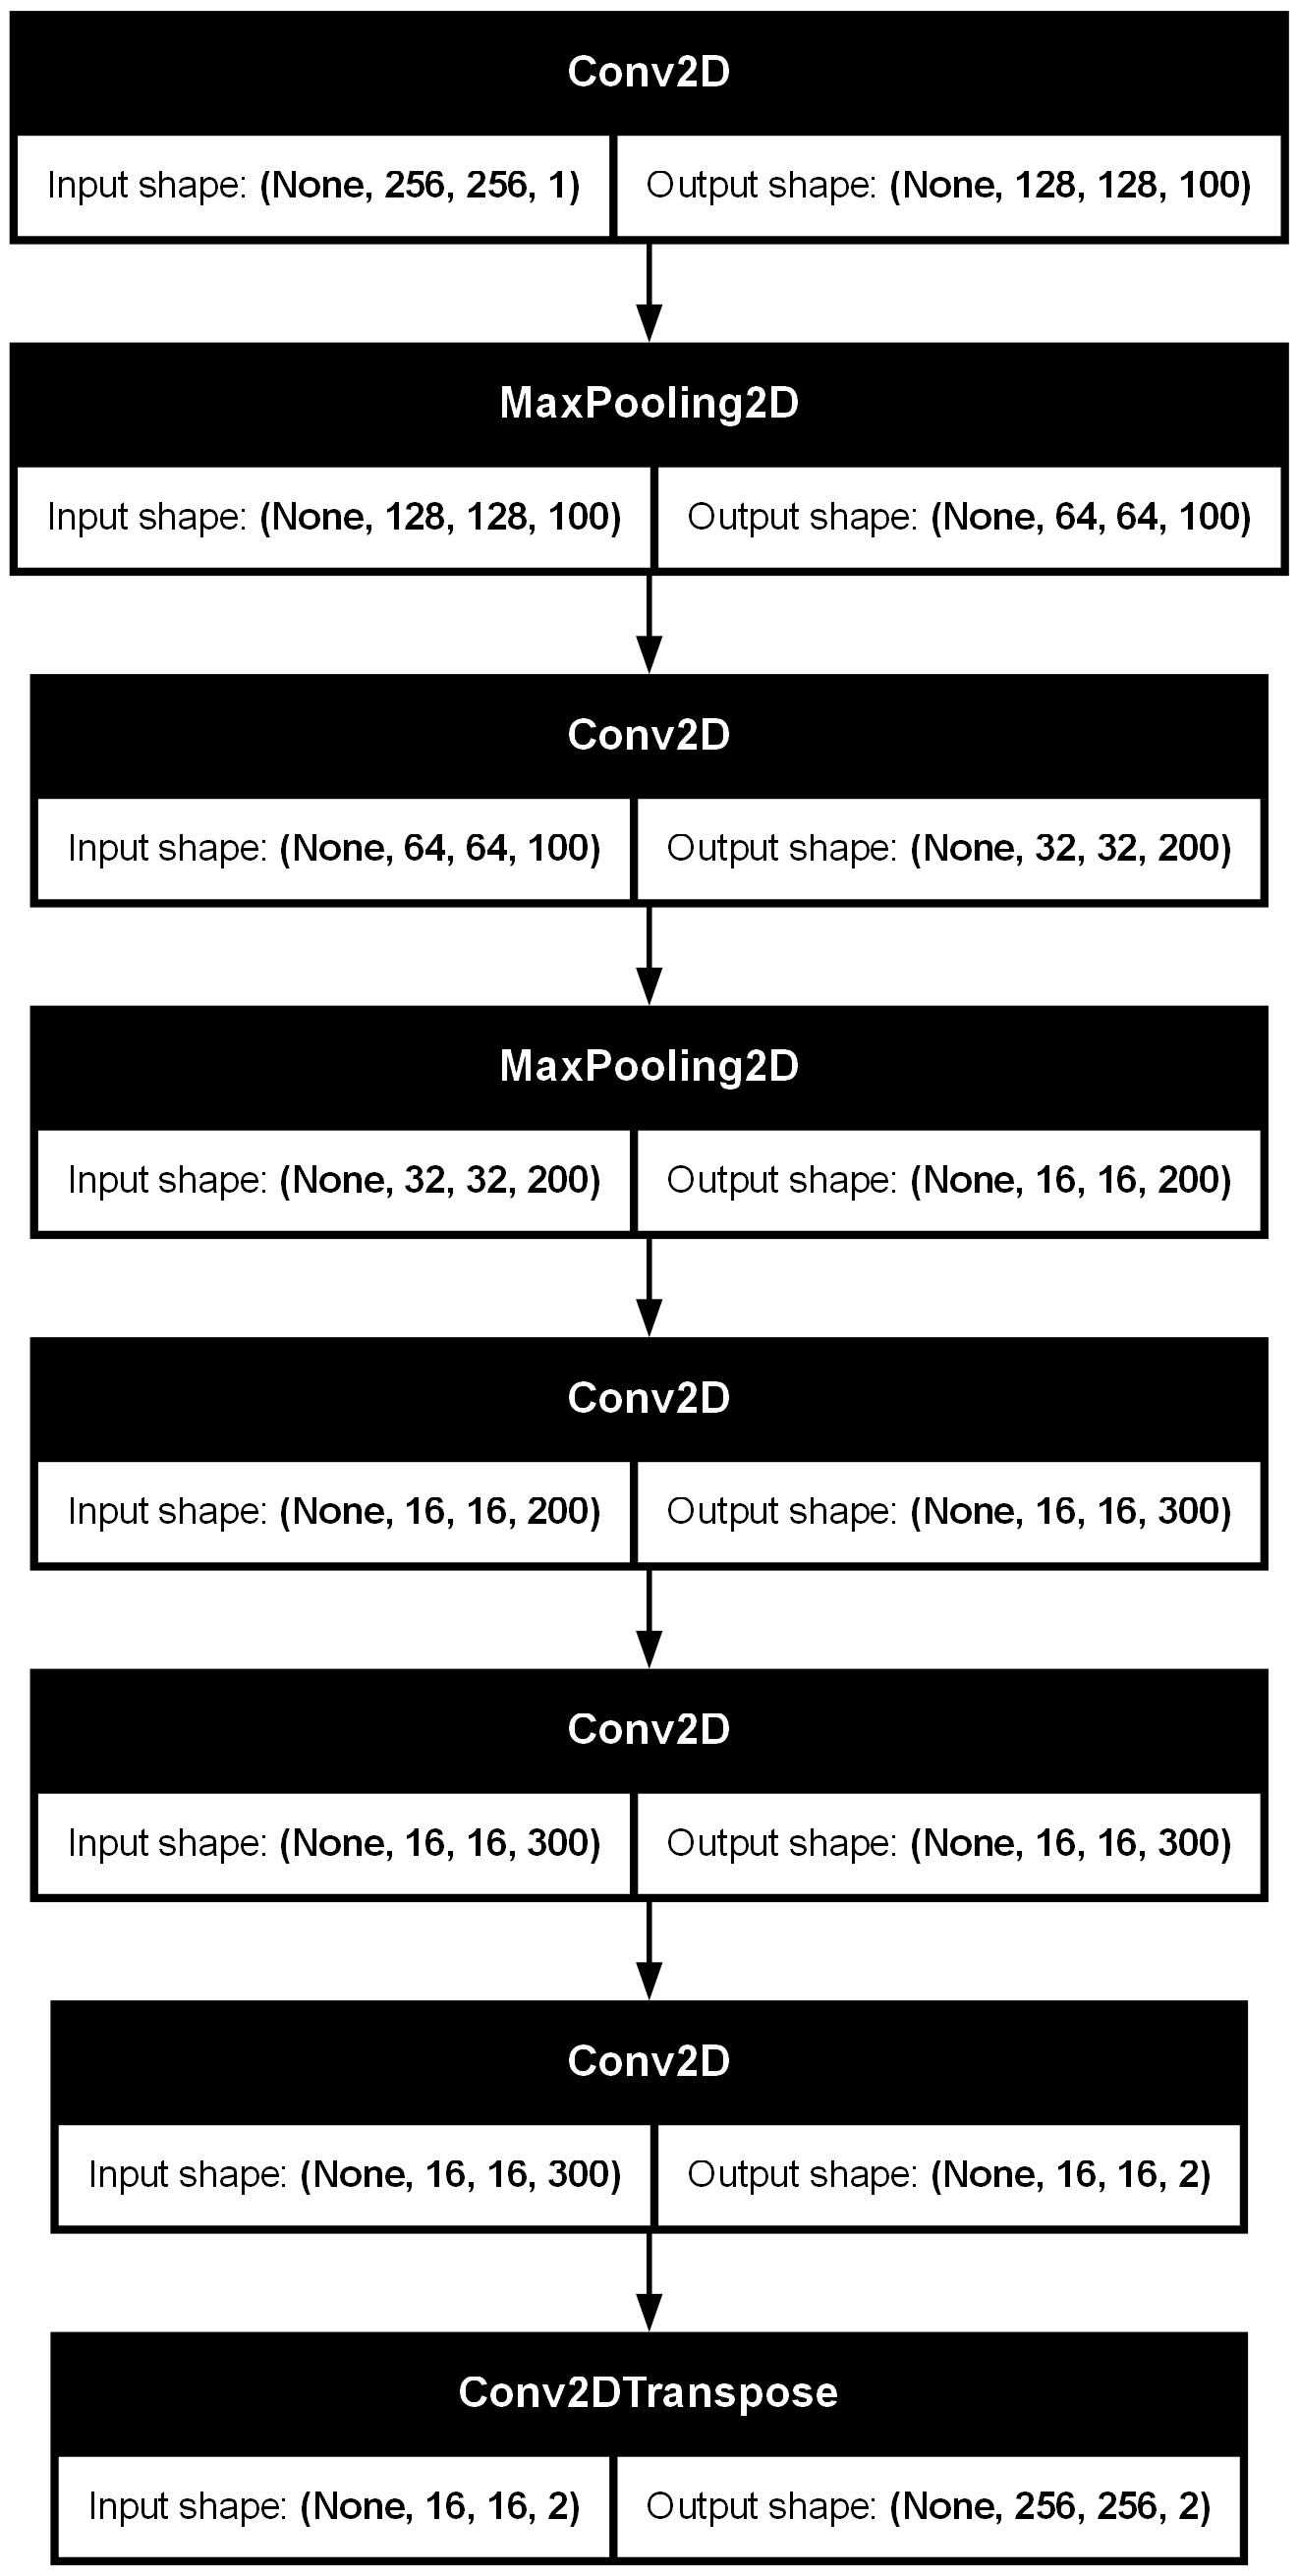

In [36]:
# plot the model including the sizes of the model
tf.keras.utils.plot_model(model, show_shapes=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


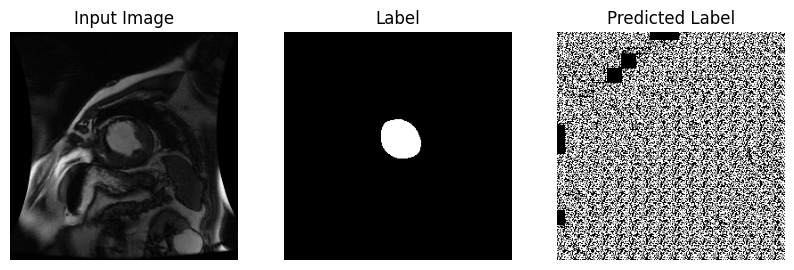

In [37]:
# show a predection, as an example
show_predictions(test_dataset)

In [38]:
# Initialize new directories for new task
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/stepstep - accuracy: 0.9727 - loss: 0.640


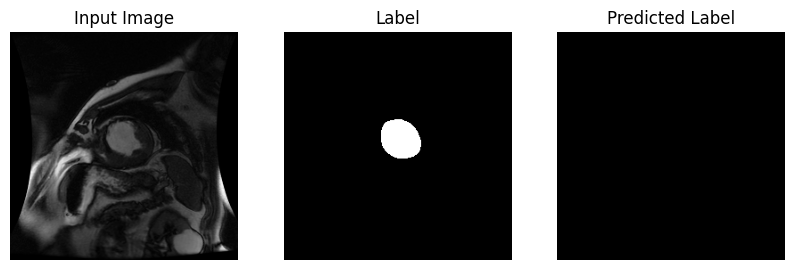


Sample Prediction after epoch 1

234/234 ━━━━━━━━━━━━━━━━━━━━ 26s 96ms/step - accuracy: 0.9727 - loss: 0.6407 - val_accuracy: 0.9830 - val_loss: 0.5037
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/stepstep - accuracy: 0.9847 - loss: 0.467


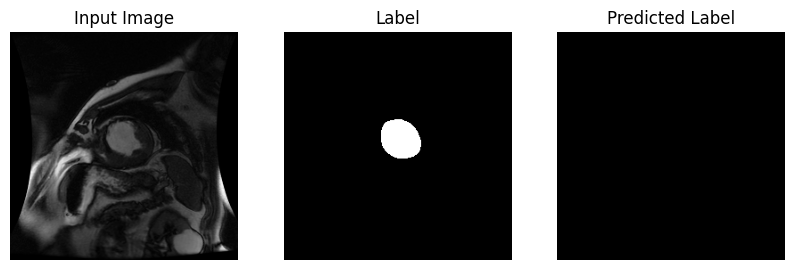


Sample Prediction after epoch 2

234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - accuracy: 0.9847 - loss: 0.4672 - val_accuracy: 0.9830 - val_loss: 0.3759
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/steptep - accuracy: 0.9843 - loss: 0.35


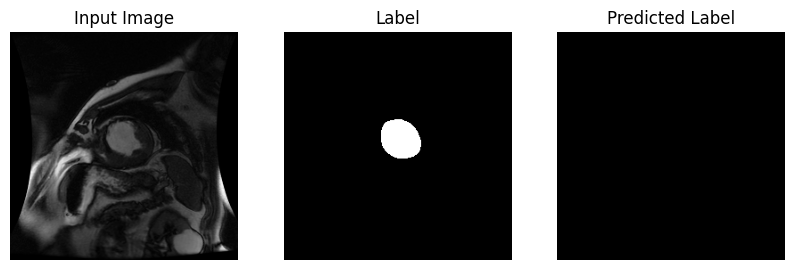


Sample Prediction after epoch 3

234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - accuracy: 0.9843 - loss: 0.3509 - val_accuracy: 0.9830 - val_loss: 0.2905
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/stepstep - accuracy: 0.9845 - loss: 0.272


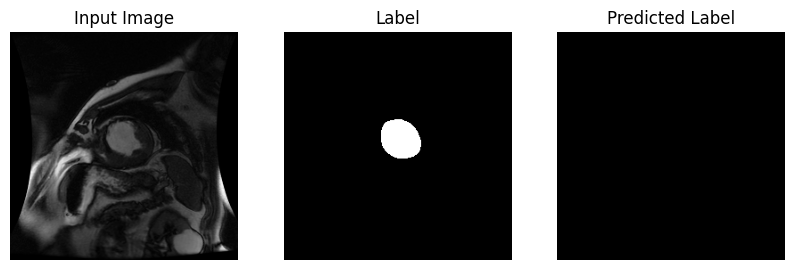


Sample Prediction after epoch 4

234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9845 - loss: 0.2726 - val_accuracy: 0.9830 - val_loss: 0.2328
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/stepstep - accuracy: 0.9844 - loss: 0.219


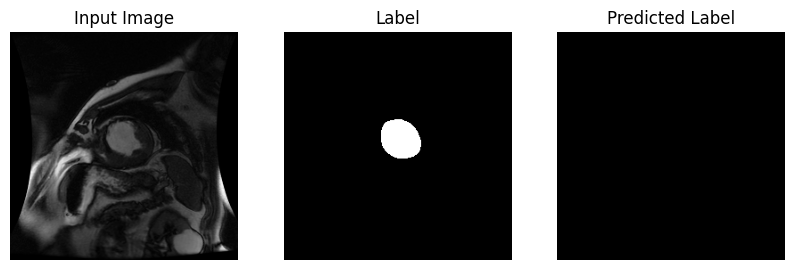


Sample Prediction after epoch 5

234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 94ms/step - accuracy: 0.9844 - loss: 0.2196 - val_accuracy: 0.9830 - val_loss: 0.1930
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/steptep - accuracy: 0.9848 - loss: 0.182


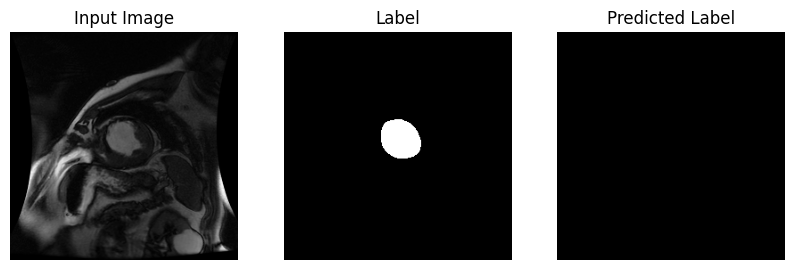


Sample Prediction after epoch 6

234/234 ━━━━━━━━━━━━━━━━━━━━ 23s 98ms/step - accuracy: 0.9848 - loss: 0.1820 - val_accuracy: 0.9830 - val_loss: 0.1650
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/stepstep - accuracy: 0.9847 - loss: 0.156


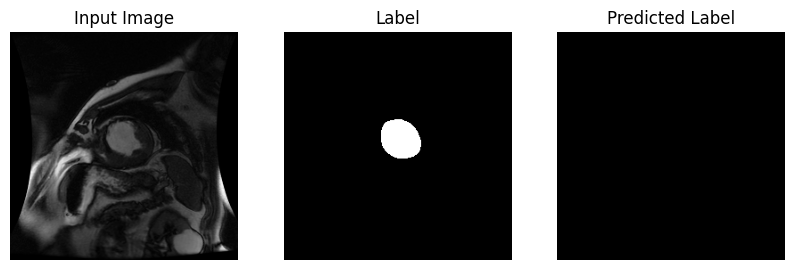


Sample Prediction after epoch 7

234/234 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.9847 - loss: 0.1560 - val_accuracy: 0.9830 - val_loss: 0.1449
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/stepstep - accuracy: 0.9845 - loss: 0.137


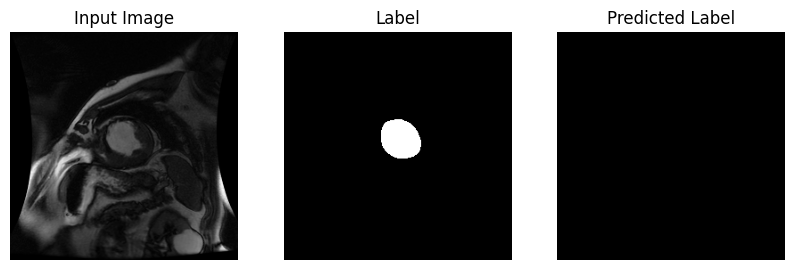


Sample Prediction after epoch 8

234/234 ━━━━━━━━━━━━━━━━━━━━ 24s 101ms/step - accuracy: 0.9845 - loss: 0.1375 - val_accuracy: 0.9830 - val_loss: 0.1301
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/stepstep - accuracy: 0.9846 - loss: 0.123


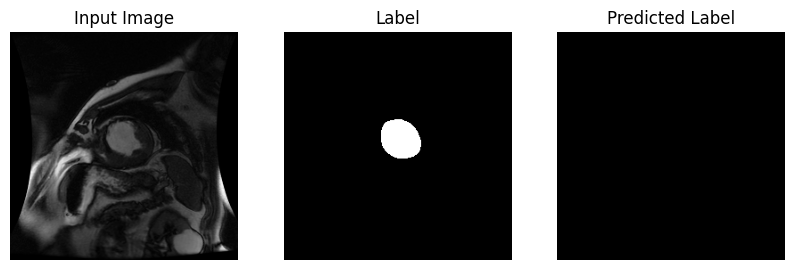


Sample Prediction after epoch 9

234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.9846 - loss: 0.1233 - val_accuracy: 0.9830 - val_loss: 0.1192
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/stepstep - accuracy: 0.9848 - loss: 0.112


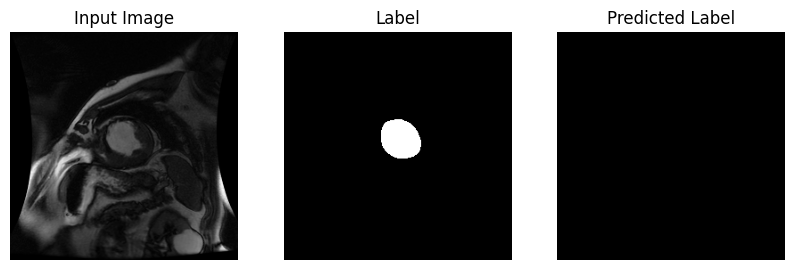


Sample Prediction after epoch 10

234/234 ━━━━━━━━━━━━━━━━━━━━ 21s 92ms/step - accuracy: 0.9848 - loss: 0.1122 - val_accuracy: 0.9830 - val_loss: 0.1110
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/stepstep - accuracy: 0.9848 - loss: 0.104


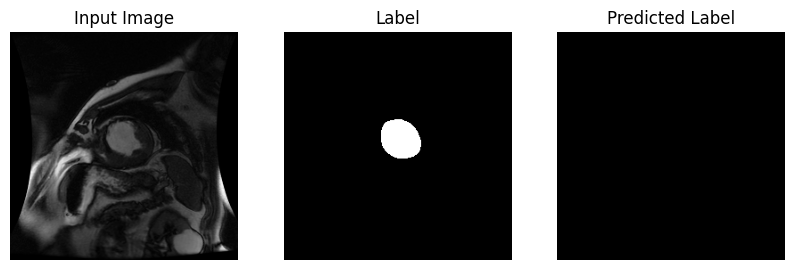


Sample Prediction after epoch 11

234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9848 - loss: 0.1044 - val_accuracy: 0.9830 - val_loss: 0.1049
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/stepstep - accuracy: 0.9846 - loss: 0.098


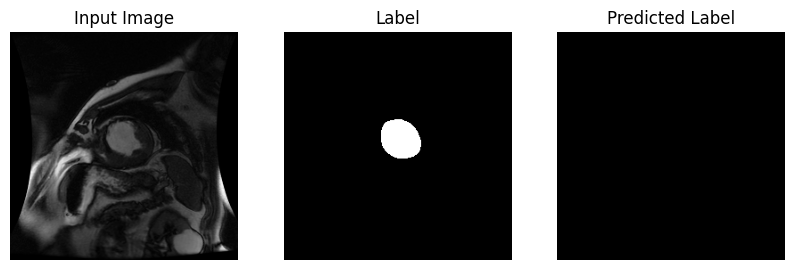


Sample Prediction after epoch 12

234/234 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.9846 - loss: 0.0988 - val_accuracy: 0.9830 - val_loss: 0.1002
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/stepstep - accuracy: 0.9847 - loss: 0.094


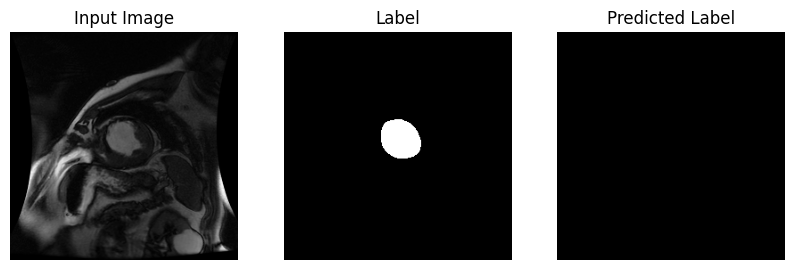


Sample Prediction after epoch 13

234/234 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.9847 - loss: 0.0940 - val_accuracy: 0.9830 - val_loss: 0.0966
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/stepstep - accuracy: 0.9846 - loss: 0.090


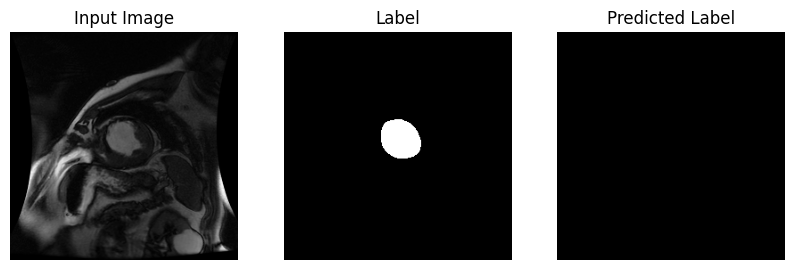


Sample Prediction after epoch 14

234/234 ━━━━━━━━━━━━━━━━━━━━ 21s 90ms/step - accuracy: 0.9846 - loss: 0.0908 - val_accuracy: 0.9830 - val_loss: 0.0938
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/steptep - accuracy: 0.9847 - loss: 0.087


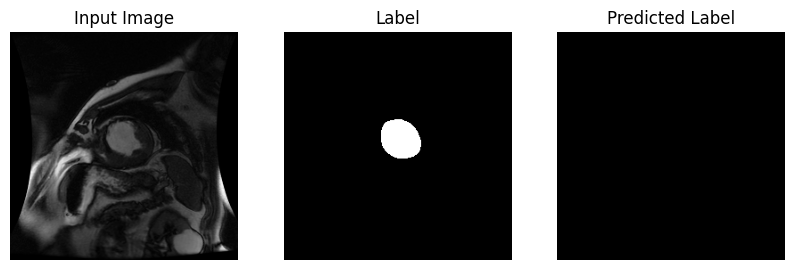


Sample Prediction after epoch 15

234/234 ━━━━━━━━━━━━━━━━━━━━ 23s 97ms/step - accuracy: 0.9847 - loss: 0.0877 - val_accuracy: 0.9830 - val_loss: 0.0918
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/stepstep - accuracy: 0.9849 - loss: 0.085


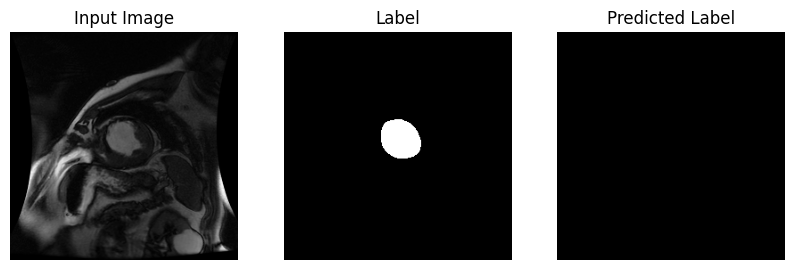


Sample Prediction after epoch 16

234/234 ━━━━━━━━━━━━━━━━━━━━ 23s 97ms/step - accuracy: 0.9849 - loss: 0.0850 - val_accuracy: 0.9830 - val_loss: 0.0902
Epoch 17/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/stepstep - accuracy: 0.9847 - loss: 0.083


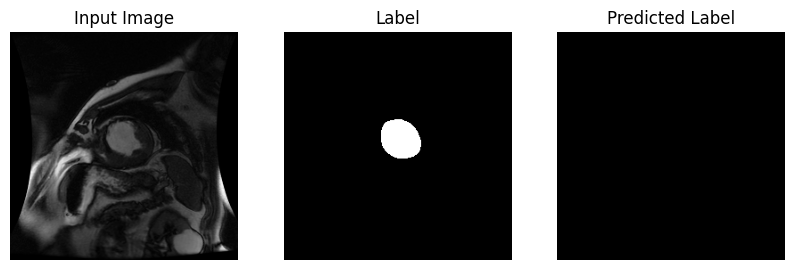


Sample Prediction after epoch 17

234/234 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.9847 - loss: 0.0839 - val_accuracy: 0.9830 - val_loss: 0.0890
Epoch 18/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/stepstep - accuracy: 0.9850 - loss: 0.081


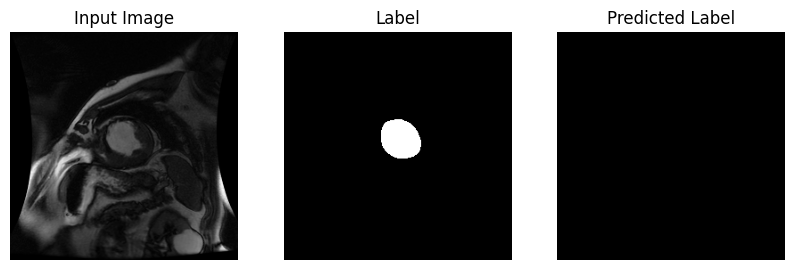


Sample Prediction after epoch 18

234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.9850 - loss: 0.0817 - val_accuracy: 0.9830 - val_loss: 0.0882
Epoch 19/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/stepstep - accuracy: 0.9843 - loss: 0.083


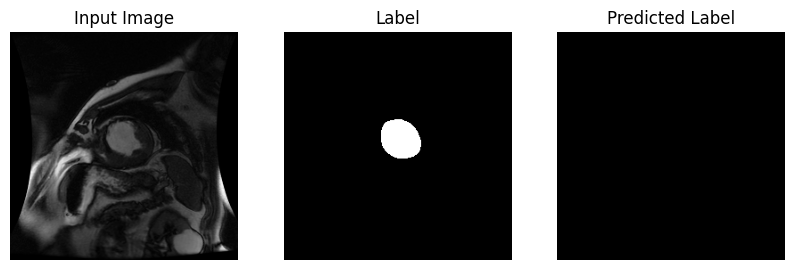


Sample Prediction after epoch 19

234/234 ━━━━━━━━━━━━━━━━━━━━ 23s 98ms/step - accuracy: 0.9843 - loss: 0.0832 - val_accuracy: 0.9830 - val_loss: 0.0875
Epoch 20/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/stepstep - accuracy: 0.9847 - loss: 0.080


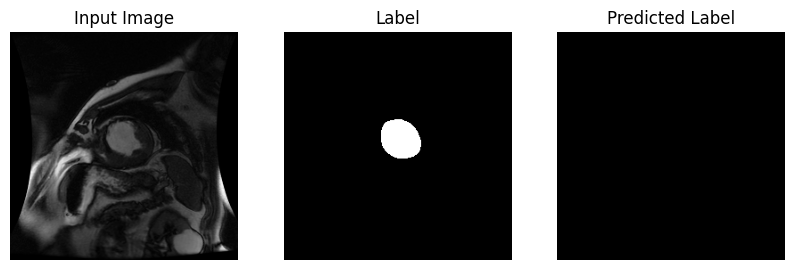


Sample Prediction after epoch 20

234/234 ━━━━━━━━━━━━━━━━━━━━ 22s 95ms/step - accuracy: 0.9847 - loss: 0.0808 - val_accuracy: 0.9830 - val_loss: 0.0871


In [39]:
# setup and run the model
EPOCHS = 20
STEPS_PER_EPOCH = len(list(parsed_training_dataset))
VALIDATION_STEPS = 26

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback(), tensorboard_callback])

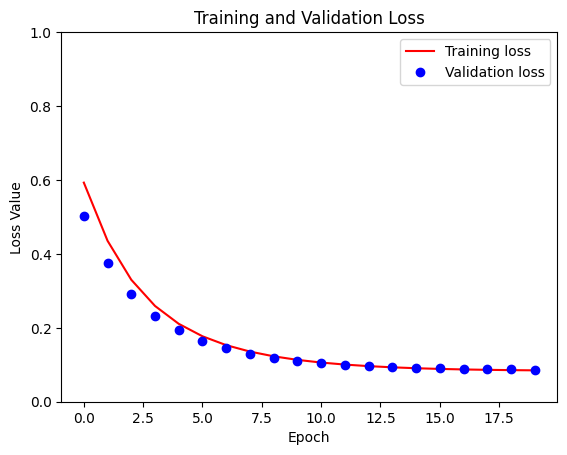

In [40]:
# output model statistics
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
accuracy = model_history.history['accuracy']
val_accuracy = model_history.history['val_accuracy']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [41]:
model.evaluate(test_dataset)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.9796 - loss: 0.0997


[0.08710534125566483, 0.9829577207565308]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step


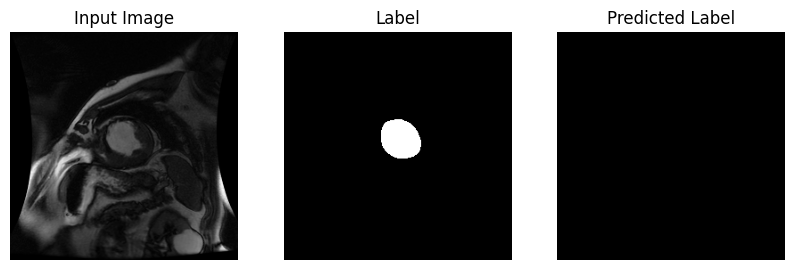

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


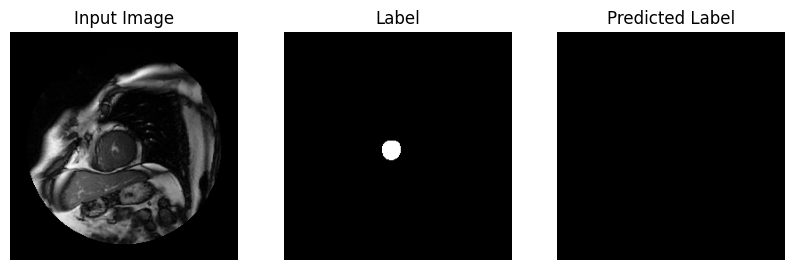

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


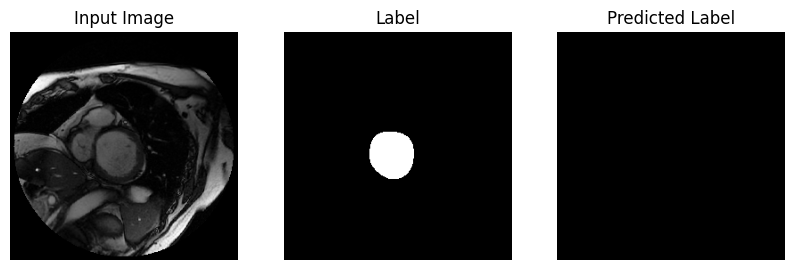

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


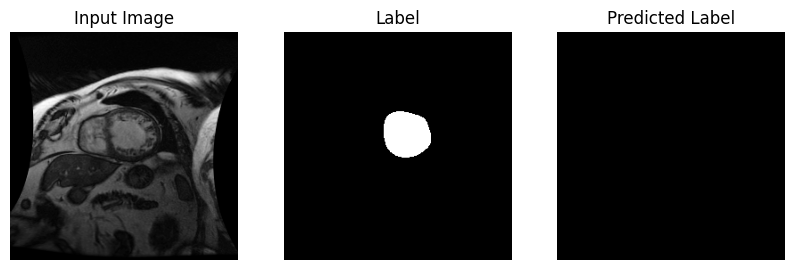

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


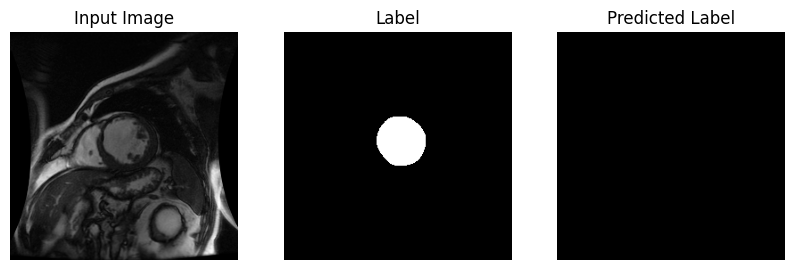

In [42]:
# show predictions from the test data set that has NOT been used for training.
show_predictions(test_dataset, 5)